In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

_HEIGHT = 1.0
_VEL_CONST = 1.0
_TIME_STEP = 0.1

## Plant Dynamics, Sensors, and Actuators

the following object contains functions for the plant dynamics, sensing of the target angle $\gamma$, and actuator for $v_{cmd}$

In [2]:
class SimpleSlideCamera():
    '''Object that defines the dynamics of the simple slide-camera'''
    
    def __init__(self, x_0, v_0, x_d, gamma_d=0.0, h=_HEIGHT):
        
        # state variables (hidden)
        self.__x = x_0
        self.__v = v_0
        
        # reference position (hidden)
        self.__x_d = x_d
        
        # reference angle (observed)
        self.gamma_d = gamma_d
        
        # parameters
        self.__h = h
        
    def sense_gamma(self):
        # calculate angle from camera center line to target
        return  np.arctan2(self.__x - self.__x_d, self.__h)
    
    def _get_hidden_position(self):
        
        return self.__x
    
    def _get_hidden_position_desired(self):
        return self.__x_d
    
    def _get_hidden_velocity(self):
        return self.__v
    
    def actuate_velocity_command(self, vel_cmd, dt=_TIME_STEP):
        self.__v = vel_cmd
        self.__x += self.__v*dt
        
    def actuate_disturbed_velocity_command(self, vel_cmd, dt=_TIME_STEP, vel_bias=0.5, vel_std=0.1):
        self.__v = vel_cmd + np.random.normal(vel_bias, vel_std)
        self.__x += self.__v*dt
        
    def actuate_acceleration_command(self, acc_cmd, dt=_TIME_STEP):
        self.__v += acc_cmd*dt
        self.__x += self.__v*dt 

## Controller

In [83]:
def p_control_vel(y_err, kp):
    ''' compute the actuator command based on proportional error between output and desired output
    Args:
    y_err: y - y_des where y is the output variable of the plant
    '''
    
    # TODO: write a proportional control law (hint: it is a single line, very simple equations)
    # END TODO
    cmd =- kp* y_err
    return cmd
prev_err = 0.0
def p_control_acc(y_err, kp):
    ''' compute the actuator command based on proportional error between output and desired output
    Args:
    y_err: y - y_des where y is the output variable of the plant
    '''
    
    # TODO: write a proportional control law (hint: it is a single line, very simple equations)
    # END TODO
    global prev_err
    cmd =- kp*(y_err-prev_err)/dt
    prev_err = y_err
    return cmd

## Simulation Script

below is a script for testing various controllers for the `SimpleSlideCamera` plant as well as plotting the results.

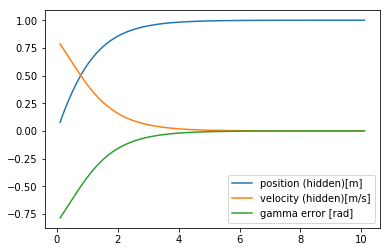

In [84]:

# Control inputs
kp = 1.0
dt = _TIME_STEP
t_final = 10.0

# intial conditions (position, velocity and targe position)
x_0 = 0.0
v_0 = 0.0
x_des = 1.0

# create SimpleSlideCamera with initial conditions
sscam = SimpleSlideCamera(x_0, v_0, x_des)

# initialize data storage
data = dict()
data['t'] = []
data['acc_cmd'] = []
data['vel_cmd'] = []
data['err_gamma'] = []
data['x_hidden'] = []
data['v_hidden'] = []
t = 0.0
err_prev = 0.0
while t < t_final:
    t += dt
    
    # SENSOR: sense output variable gamma (angle from camera centerline to target) and calculate error from desired
    err_gamma = sscam.sense_gamma() - sscam.gamma_d
    
    #print(err_gamma, t)
    
    # CONTROLLER: call velocity control algoritm
    acc_cmd = p_control_acc(err_gamma, kp)
    
    # ACTUATOR: send velocity command to plant
    sscam.actuate_acceleration_command(acc_cmd)
    
    # store data
    err_gamma_prev = err_gamma
    data['t'].append(t)
    data['vel_cmd'].append(vel_cmd)
    data['err_gamma'].append(err_gamma)
    data['x_hidden'].append(sscam._get_hidden_position())
    data['v_hidden'].append(sscam._get_hidden_velocity())
    
# Plot Data
handle_position, = plt.plot(data['t'], data['x_hidden'], label='position (hidden)[m]')
handle_velocity, = plt.plot(data['t'], data['v_hidden'], label='velocity (hidden)[m/s]')
handle_err_gamma, = plt.plot(data['t'], data['err_gamma'], label='gamma error [rad]')
plt.legend(handles=[handle_position, handle_velocity, handle_err_gamma])
plt.show()

## Questions

**1. Does your gamma error (i.e. output converge to 0.0? If so, how quickly (i.e. how long does it take for the error to be 5% of the original error)**

Yes, it takes approximately 3.4 seconds.
    
**2. What values should your system's position and velocity be converging upon? Since this is a practice problem and we want to gain understanding of how this system behaves, we've cheated and let you observe the position and velocity of the system which were meant to be unobservable in the real world. Are the position and velocity converging to values you expected?**

The position should be converging upon $x_\text{des}$, which is 1.00 meter, while the velocity is converging upon 0.0 m/s. The graph indicates that both are converging upon their expected values.

**3. As you increase the proportional gain, what happens to the rate at which the error converges to zero? **

As $K_p$ is increased, provided that it is not significantly high, the rate at which the error converges to zero increases.

  - **Can you find a proportional gain that converges within 1 second (i.e error reaches 5% of it's original value)?**
  
  Yes, when $K_p=10$, the graph converges within 1 second.
  
**4. Do you think there is such a thing as a proportional gain being too large? What could be some possible effects of setting your gain too high?**

Yes, if $K_p$ is too large, the controller "overcompensates" for the error when correcting it every time, which would create oscillating values for position, velocity, and/or error.

   - **Try it out: find gain that "breaks" the nice behavior of the system. What is the approximate value of that "threshold" gain? What is happening to the system when you set the gain higher than that threshold? Can you explain why it's behaving as it is?**
    
   The "threshold" gain is approximately $K_p=15$. After this, the system's error oscillates between positive and negative values for the gamma error, eventually dampening it down to zero. This occurs because after each iteration of the control loop, the controller sends the actuator a command that is in the opposite sign of the current error, but also of a greater magnitude due to the large $K_p$. As a result, the sign of each variable oscillates between positive and negative.
    
   - **Keeping the gain above this threshold, is there anything you could change that would fix this behavior? Is this change always possible in the real world; why or why not?**
   
   I could fix this oscillation by decreasing the sampling/loop execution time, `dt`. This is not always possible in the real world, as computatation processors run on their own clocks, which have a maximum frequency,  while sensors also have a minimum sampling time.
   
**5. What happens if you cannot perfectly control the velocity, for example there is some form of velocity disturbance that you cannot control (e.g. wind)? Let's try it out:**

   - **in the ACTUATOR portion of the simulation script, replace `actuate_velocity_command` with `actuate_disturbed_velocity_command`, restart the kernel, and run the script. Does output error (gamma error) still converge to zero? If not, what does the gamma error converge to? How might you change your controller to fix this "steady state error"**
    
   The output gamma error still converges toward zero, but it doesn't strictly approach zero. To fix this "steady state error" I might send a command telling the plant to not move (such that $v=0$) after $x$ is within a certain distance of $x_\text{des}$, so that no error is induced.
    
**6. Often times we control a system by applying a force. In this way we are not directly controlling the velocity of a system, but instead the acceleration. Let's try it out:**

   - **in the ACTUATOR portion of the simulation script replace `actuate_velocity_command` with `actuate_acceleration_command`. In the CONTROLLER portion of the script, have the controller output a acc_cmd instead of vel_cmd (just change the variable name, but this way you know it represents an acceleration instead of a velocity). Restart the kernel and rerun the script**
   
   - **Now what is happening to the gamma error, is it converging to zero? If not, is there anything you could think of to change in you controller in order to converge the error to zero?**
   
   No, now the gamma error is sinusoidal and oscillating, without its amplitude being damped. To converge the error to zero, I would change to acceleration by the derivative of $\gamma_\text{